In [1]:
# 1) 한글 폰트 설치
!apt-get -y install fonts-nanum fonts-noto-cjk > /dev/null

# 2) 매트플롯립에 폰트 등록 및 기본 폰트 지정
import matplotlib as mpl
from matplotlib import font_manager as fm
import glob, os

# 설치된 나눔/노토 폰트 경로 자동 탐색 후 등록
font_paths = []
font_paths += glob.glob("/usr/share/fonts/truetype/nanum/*.ttf")
font_paths += glob.glob("/usr/share/fonts/opentype/noto/*CJK*.otf")
font_paths += glob.glob("/usr/share/fonts/opentype/noto/*CJK*.ttc")

for p in font_paths:
    try:
        fm.fontManager.addfont(p)
    except Exception:
        pass

# 3) 기본 폰트 패밀리 지정(우선순위)
mpl.rcParams["font.family"] = ["NanumGothic", "Noto Sans CJK KR", "AppleGothic", "Malgun Gothic", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False

# 4) 폰트 캐시 재로딩(중요)
try:
    fm._load_fontmanager(try_read_cache=False)  # Matplotlib >=3.6 권장
except Exception:
    fm._rebuild()  # 구버전 대응

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

DATE_COL_PATTERN = re.compile(r'^\s*\d{4}\.(?:0?[1-9]|1[0-2])\s*$')

def to_month_end_datetime(s):
    s = str(s).strip()
    s = re.sub(r'\s*p\)\s*$', '', s)   # ' p)' 제거
    dt = pd.to_datetime(s, format='%Y.%m', errors='coerce')
    if pd.isna(dt):
        return pd.NaT
    return pd.Period(dt, freq='M').to_timestamp(how='end')

def detect_date_columns(df):
    return [c for c in df.columns if DATE_COL_PATTERN.match(str(c))]

def melt_wide_monthly(df, id_col=None):
    date_cols = detect_date_columns(df)
    if not date_cols:
        return None
    id_vars = [id_col] if (id_col is not None and id_col in df.columns) else []
    long_df = df.melt(id_vars=id_vars, value_vars=date_cols,
                      var_name='DateStr', value_name='Value')
    long_df['Date'] = long_df['DateStr'].apply(to_month_end_datetime)
    long_df = long_df[['Date','Value']].dropna().sort_values('Date')
    return long_df

def load_series_auto(csv_path, preferred_label_col=None, preferred_label_value=None):
    last_err = None
    for enc in ['utf-8-sig','cp949','euc-kr','utf-8']:
        try:
            df = pd.read_csv(csv_path, encoding=enc)
            break
        except Exception as e:
            last_err = e
            df = None
    if df is None:
        raise RuntimeError(f"CSV 읽기 실패: {last_err}")

    if preferred_label_col and preferred_label_col in df.columns and preferred_label_value is not None:
        df = df[df[preferred_label_col].astype(str).str.strip() == str(preferred_label_value).strip()]

    long_df = melt_wide_monthly(df, id_col=preferred_label_col if (df is not None and preferred_label_col in df.columns) else None)
    if long_df is not None and not long_df.empty:
        s = pd.Series(long_df['Value'].astype(float).values, index=long_df['Date'].values)
        s = s[~s.index.duplicated(keep='last')].sort_index()
        return s

    date_candidates = [c for c in df.columns if str(c).strip() in ['Date','날짜','기간','기준월','월']]
    val_candidates  = [c for c in df.columns if str(c).strip() in ['Value','값','지수','지표값','Index','IndexValue','값(지수)']]
    if not val_candidates:
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if len(numeric_cols) == 1:
            val_candidates = numeric_cols

    if date_candidates and val_candidates:
        dcol, vcol = date_candidates[0], val_candidates[0]
        tmp = df[[dcol, vcol]].copy()
        tmp['Date'] = tmp[dcol].apply(lambda x: to_month_end_datetime(x) if pd.notna(x) else pd.NaT)
        tmp = tmp[['Date', vcol]].dropna().rename(columns={vcol:'Value'})
        s = pd.Series(tmp['Value'].astype(float).values, index=tmp['Date'].values)
        s = s[~s.index.duplicated(keep='last')].sort_index()
        return s

    raise ValueError(f"형식 자동 인식 실패. 열 목록: {list(df.columns)}")

def bk_cycle(series_log, low=18, high=96, K=12):
    cyc = sm.tsa.filters.bkfilter(series_log.dropna(), low=low, high=96, K=K)
    cyc.name = 'cycle'
    return cyc

def zscore_over_overlap(s1, s2):
    common_idx = s1.index.intersection(s2.index)
    a = s1.loc[common_idx]
    b = s2.loc[common_idx]
    az = (a - a.mean()) / a.std(ddof=0)
    bz = (b - b.mean()) / b.std(ddof=0)
    return az, bz

def normalize_base100_over_overlap(level1, level2):
    common_idx = level1.index.intersection(level2.index)
    a = level1.loc[common_idx].astype(float)
    b = level2.loc[common_idx].astype(float)
    a_norm = a / a.iloc[0] * 100.0
    b_norm = b / b.iloc[0] * 100.0
    return a_norm, b_norm

In [3]:
from google.colab import files
uploaded = files.upload()
list(uploaded.keys())

Saving ip_index.csv to ip_index.csv
Saving machine_noship.csv to machine_noship.csv


['ip_index.csv', 'machine_noship.csv']

In [4]:
# 파일명 (셀2에서 올린 실제 이름과 동일하게)
ip_csv       = 'ip_index.csv'
machine_csv  = 'machine_noship.csv'  # 이름을 바꿨다면 그 이름으로

import re, numpy as np, pandas as pd, statsmodels.api as sm

# (보강) 날짜 파서/패턴이 기존 셀1에 없을 수도 있으니 안전장치로 함께 정의
re_dot   = re.compile(r'^\s*\d{4}\.(?:0?[1-9]|1[0-2])\s*$')
re_slash = re.compile(r'^\s*\d{4}/(?:0?[1-9]|1[0-2])\s*$')
re_dash  = re.compile(r'^\s*\d{4}-(?:0?[1-9]|1[0-2])\s*$')

def _to_month_end_generic(s):
    s = str(s).strip()
    s = re.sub(r'\s*p\)\s*$', '', s)
    for fmt in ['%Y.%m', '%Y/%m', '%Y-%m']:
        try:
            dt = pd.to_datetime(s, format=fmt)
            return pd.Period(dt, freq='M').to_timestamp(how='end')
        except Exception:
            pass
    return pd.NaT

# --- 전산업생산지수 ---
# 인코딩 자동 시도
ip_df = None
for enc in ['utf-8-sig','cp949','euc-kr','utf-8']:
    try:
        ip_df = pd.read_csv(ip_csv, encoding=enc)
        break
    except Exception:
        pass
assert ip_df is not None, "ip_index.csv 읽기 실패"

# 전산업생산지수 행만
ip_df = ip_df[ip_df['산업별 지수'].astype(str).str.strip() == '전산업생산지수']

# 날짜열 선별 → long → Series
ip_date_cols = [c for c in ip_df.columns if re_dot.match(str(c)) or re_slash.match(str(c)) or re_dash.match(str(c))]
long_ip = ip_df.melt(id_vars=['산업별 지수'], value_vars=ip_date_cols, var_name='DateStr', value_name='Value')
long_ip['Date'] = long_ip['DateStr'].apply(_to_month_end_generic)
ip_level = pd.Series(pd.to_numeric(long_ip['Value'], errors='coerce').values, index=long_ip['Date']).dropna()
ip_level = ip_level[~ip_level.index.duplicated(keep='last')].sort_index()

# --- 기계설비류(선박제외) 내수출하지수(계절조정) ---
mach_df = None
for enc in ['utf-8-sig','cp949','euc-kr','utf-8']:
    try:
        mach_df = pd.read_csv(machine_csv, encoding=enc)
        break
    except Exception:
        pass
assert mach_df is not None, "설비용 기계류 생산지수.csv 읽기 실패"

row = mach_df[
    (mach_df['구분코드'].astype(str).str.strip() == '기계설비류(선박제외)') &
    (mach_df['계정항목'].astype(str).str.strip() == '내수출하지수(계절조정)')
]
if row.empty:
    # 디버깅 힌트
    print("구분코드 unique:", sorted(mach_df['구분코드'].astype(str).str.strip().unique()))
    print("계정항목 unique:", sorted(mach_df['계정항목'].astype(str).str.strip().unique()))
    raise ValueError("대상 행(기계설비류(선박제외), 내수출하지수(계절조정))을 찾지 못함")

mach_date_cols = [c for c in row.columns if re_dot.match(str(c)) or re_slash.match(str(c)) or re_dash.match(str(c))]
long_m = row.melt(value_vars=mach_date_cols, var_name='DateStr', value_name='Value')
long_m['Date'] = long_m['DateStr'].apply(_to_month_end_generic)
mach_level = pd.Series(pd.to_numeric(long_m['Value'], errors='coerce').values, index=long_m['Date']).dropna()
mach_level = mach_level[~mach_level.index.duplicated(keep='last')].sort_index()

# 범위 출력
def _span(s): return s.index.min().date(), s.index.max().date(), s.shape[0]
print("IP 범위:", _span(ip_level))
print("기계설비(선박제외) 내수출하지수 범위:", _span(mach_level))

# 로그 → BK(18~96, K=12)
ip_log   = np.log(ip_level.astype(float))
mach_log = np.log(mach_level.astype(float))

ip_cycle   = sm.tsa.filters.bkfilter(ip_log.dropna(),   low=18, high=96, K=12)
mach_cycle = sm.tsa.filters.bkfilter(mach_log.dropna(), low=18, high=96, K=12)

# 공통 구간
common_idx = ip_cycle.dropna().index.intersection(mach_cycle.dropna().index)
print("공통 구간:", common_idx.min().date(), "→", common_idx.max().date(), f"({len(common_idx)}개월)")

IP 범위: (datetime.date(2000, 1, 31), datetime.date(2025, 4, 30), 304)
기계설비(선박제외) 내수출하지수 범위: (datetime.date(2000, 1, 31), datetime.date(2025, 6, 30), 306)
공통 구간: 2001-01-31 → 2024-04-30 (280개월)


z-score 상관계수: 0.507
최고 교차상관: lag=-3개월, corr=0.657
해석: 전산업생산이 선행


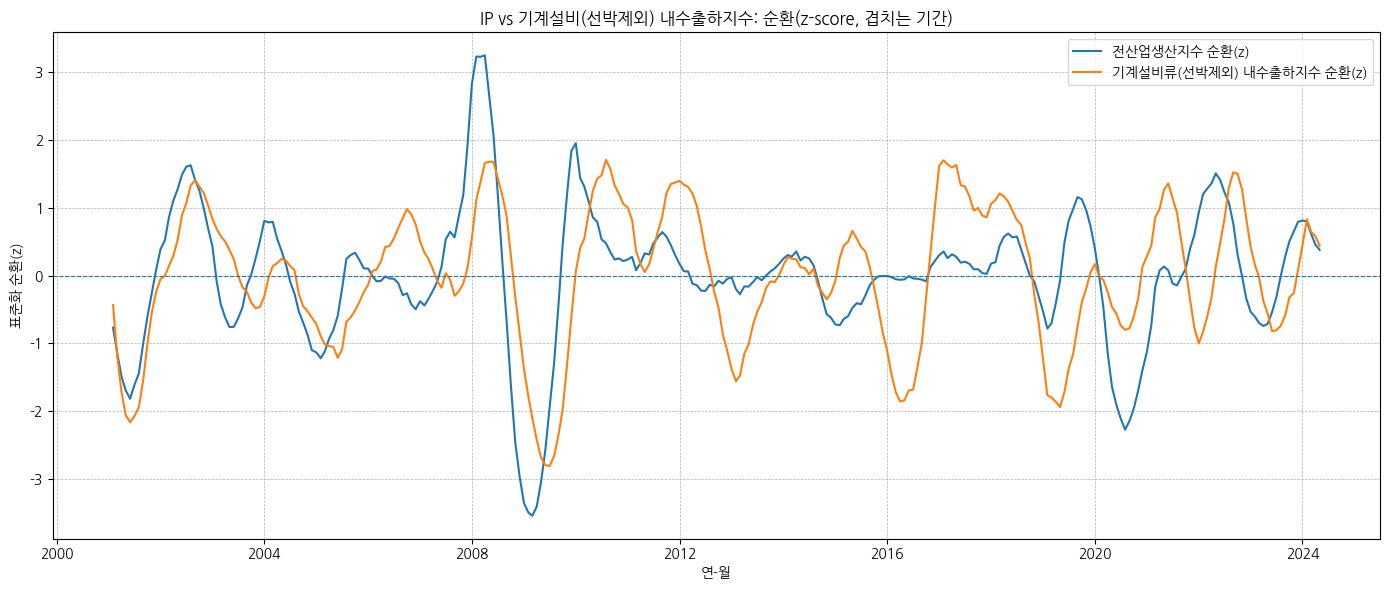

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# z-score 표준화(겹치는 기간)
idx = ip_cycle.dropna().index.intersection(mach_cycle.dropna().index)
ip_c   = ip_cycle.loc[idx]
mach_c = mach_cycle.loc[idx]
ip_z   = (ip_c - ip_c.mean()) / ip_c.std(ddof=0)
mach_z = (mach_c - mach_c.mean()) / mach_c.std(ddof=0)

# 상관계수
pearson_r = ip_z.corr(mach_z)
print("z-score 상관계수:", round(float(pearson_r), 3))

# 간단 교차상관(±12개월)로 선행/후행 탐색
def best_lag(a, b, max_lag=12):
    best = (0, a.corr(b))
    for lag in range(-max_lag, max_lag+1):
        if lag == 0:
            continue
        corr = a.corr(b.shift(lag))
        if pd.notna(corr) and corr > best[1]:
            best = (lag, corr)
    return best

lag, lag_corr = best_lag(ip_z, mach_z, max_lag=12)
print(f"최고 교차상관: lag={lag}개월, corr={round(float(lag_corr),3)}")
print("해석:",
      "기계설비류(선박제외) 내수출하지수가 선행" if lag>0 else
      "전산업생산이 선행" if lag<0 else "뚜렷한 선행·후행 없음")

# 시각화
plt.figure(figsize=(14,6))
plt.plot(ip_z.index,   ip_z.values,   label='전산업생산지수 순환(z)')
plt.plot(mach_z.index, mach_z.values, label='기계설비류(선박제외) 내수출하지수 순환(z)')
plt.axhline(0, linestyle='--', linewidth=0.8)
plt.title('IP vs 기계설비(선박제외) 내수출하지수: 순환(z-score, 겹치는 기간)')
plt.xlabel('연-월'); plt.ylabel('표준화 순환(z)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(); plt.tight_layout(); plt.show()

In [6]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np

# 공통 구간 정렬
idx = ip_cycle.dropna().index.intersection(mach_cycle.dropna().index)

# (1) mach_cycle ~ ip_cycle
y = mach_cycle.loc[idx].values
X = sm.add_constant(ip_cycle.loc[idx].values)
m1 = sm.OLS(y, X).fit()
print("[mach ← ip] R²:", round(m1.rsquared, 3),
      "RMSE:", round(float(np.sqrt(mean_squared_error(y, m1.predict(X)))), 3))

# (2) ip_cycle ~ mach_cycle (참고)
y2 = ip_cycle.loc[idx].values
X2 = sm.add_constant(mach_cycle.loc[idx].values)
m2 = sm.OLS(y2, X2).fit()
print("[ip ← mach]  R²:", round(m2.rsquared, 3),
      "RMSE:", round(float(np.sqrt(mean_squared_error(y2, m2.predict(X2)))), 3))

# 상세 회귀표가 필요하면 아래 주석 해제
# print(m1.summary())
# print(m2.summary())

[mach ← ip] R²: 0.257 RMSE: 0.021
[ip ← mach]  R²: 0.257 RMSE: 0.008


저장: ip_vs_machine_z.png, cycles_ip_machine.csv


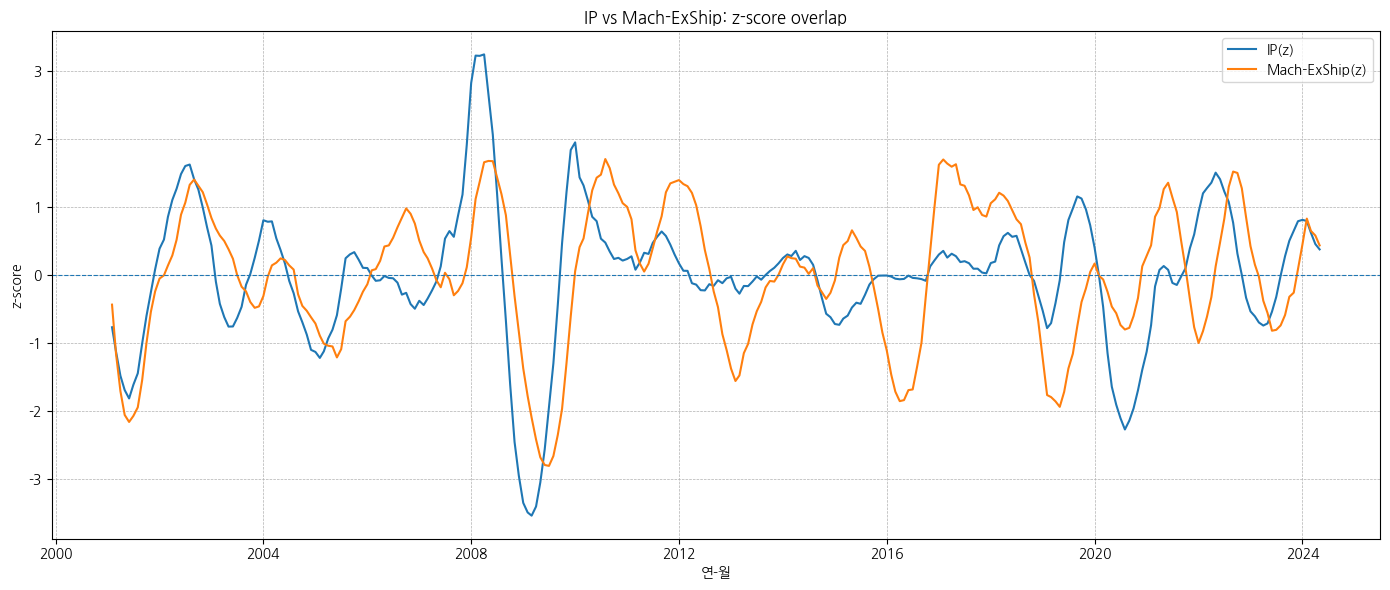

In [7]:
# 그래프 저장
plt.figure(figsize=(14,6))
plt.plot(ip_z.index, ip_z.values, label='IP(z)')
plt.plot(mach_z.index, mach_z.values, label='Mach-ExShip(z)')
plt.axhline(0, linestyle='--', linewidth=0.8)
plt.title('IP vs Mach-ExShip: z-score overlap')
plt.xlabel('연-월'); plt.ylabel('z-score')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(); plt.tight_layout()
plt.savefig('ip_vs_machine_z.png', dpi=150)

# 원시 순환 성분 저장
pd.DataFrame({'IP_cycle': ip_cycle, 'Mach_cycle': mach_cycle}).dropna().to_csv('cycles_ip_machine.csv', encoding='utf-8-sig')
print("저장: ip_vs_machine_z.png, cycles_ip_machine.csv")